In [1]:
import sys
sys.path.append('../Modules')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

def create_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(*domain, sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def kernel(x, y, param = [1, 15, 0, 0], pairwise=True):
    if pairwise:
        x, y = (np.tile(x, (len(y), 1)).transpose(1, 0), np.tile(y, (len(x), 1)))
    return param[0] * np.exp(-0.5 * param[1] * (x - y) ** 2) + param[2] + param[3] * np.multiply(x, y)

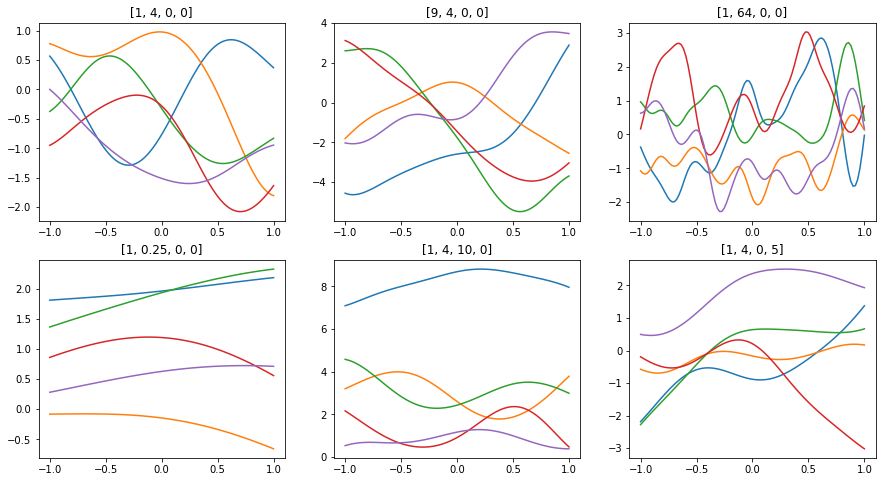

In [2]:
x = np.linspace(-1, 1, 100)
params = [[1, 4, 0, 0], 
          [9, 4, 0 , 0],
          [1, 64, 0, 0],
          [1, 0.25, 0, 0],
          [1, 4, 10, 0],
          [1, 4, 0, 5]]

plt.figure(figsize=(15, 8))
for n in range(len(params)):
    plt.subplot(2, 3, n+1)
    plt.gca().set_title("{}".format(params[n]))
    y = np.random.multivariate_normal(np.zeros(len(x)), kernel(x, x, params[n]), 5)
    for i in range(5):
        plt.plot(x, y[i], label=params[0])
plt.show()

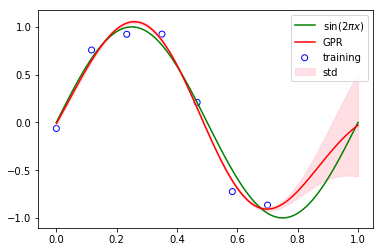

In [3]:
np.random.seed(1234)
x_train, t_train = create_data(sinusoidal, 7, std=0.1, domain=[0., 0.7])
x = np.linspace(0, 1, 100)

beta = 100
I = np.eye(len(x_train))

Gram = kernel(x_train, x_train)
K = kernel(x, x_train)
covariance = Gram + I / beta # (6.62) 
precision = np.linalg.inv(covariance)
t = K @ precision @ t_train  # (6.66)
t_std = kernel(x, x, pairwise=False) + 1 / beta - np.sum(K @ precision * K, axis=1)  # (6.67)

plt.scatter(x_train, t_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, t, color="r", label="GPR")
plt.fill_between(x, t - t_std, t + t_std, alpha=0.5, color="pink", label="std")
plt.legend()
plt.show()

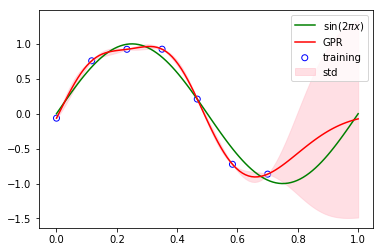

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

kernel = ConstantKernel(1) * RBF(1/np.sqrt(15), (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(x_train.reshape(-1,1), t_train)

t, t_std = gp.predict(x.reshape(-1,1), return_std=True)
plt.scatter(x_train, t_train, facecolor="none", edgecolor="b", color="blue", label="training")
plt.plot(x, sinusoidal(x), color="g", label="sin$(2\pi x)$")
plt.plot(x, t, color="r", label="GPR")
plt.fill_between(x, t - 2*t_std, t + 2*t_std, alpha=0.5, color="pink", label="std")
plt.legend()
plt.show()